# Sarcasm Sentiment Analysis with Embedding

In [1]:
import json
import tensorflow as tf
print(tf.__version__)
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2.2.0-rc1


In [2]:
#vocab_size = 10000 shorter improves loss
vocab_size = 1000

embedding_dim = 16

#max_length = 100 shorter improves loss
max_length = 16

trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [3]:
# Download data set
import wget

url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json'
wget.download(url)

print('Finished download')

Finished download


In [4]:
# transfer from json to a sentences and labels lists

with open(f'{os.getcwd()}\\Sarcasm_Data\\sarcasm.json', 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [5]:
# train/test split

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
# Step 1 instantiate tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Step 2 fit tokenizer
tokenizer.fit_on_texts(training_sentences)

# Step 3 use fitted tokenizer to create word indexes
word_index = tokenizer.word_index

# Step 4 use word index to create number sequences (train)
training_sequences = tokenizer.texts_to_sequences(training_sentences)

# Step 5 pad sequences to same length (train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Step 4 use word index to create number sequences (test)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

# Step 5 pad sequences to same length (test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [7]:
# np arrays needed for TF2.0
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 16,433
Trainable params: 16,433
Non-trainable params: 0
_________________________________________________________________


In [10]:
# train
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 2s - loss: 0.5223 - accuracy: 0.7423 - val_loss: 0.4162 - val_accuracy: 0.8038
Epoch 2/30
625/625 - 2s - loss: 0.3788 - accuracy: 0.8276 - val_loss: 0.3986 - val_accuracy: 0.8170
Epoch 3/30
625/625 - 2s - loss: 0.3632 - accuracy: 0.8353 - val_loss: 0.3995 - val_accuracy: 0.8137
Epoch 4/30
625/625 - 2s - loss: 0.3577 - accuracy: 0.8375 - val_loss: 0.4011 - val_accuracy: 0.8147
Epoch 5/30
625/625 - 2s - loss: 0.3554 - accuracy: 0.8385 - val_loss: 0.4066 - val_accuracy: 0.8128
Epoch 6/30
625/625 - 2s - loss: 0.3527 - accuracy: 0.8397 - val_loss: 0.4037 - val_accuracy: 0.8143
Epoch 7/30
625/625 - 2s - loss: 0.3492 - accuracy: 0.8407 - val_loss: 0.4019 - val_accuracy: 0.8122
Epoch 8/30
625/625 - 2s - loss: 0.3465 - accuracy: 0.8427 - val_loss: 0.4057 - val_accuracy: 0.8092
Epoch 9/30
625/625 - 2s - loss: 0.3419 - accuracy: 0.8444 - val_loss: 0.3970 - val_accuracy: 0.8182
Epoch 10/30
625/625 - 2s - loss: 0.3385 - accuracy: 0.8478 - val_loss: 0.3984 - val_accuracy: 0.8185

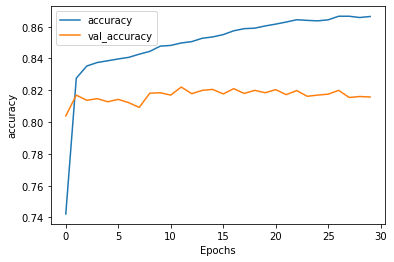

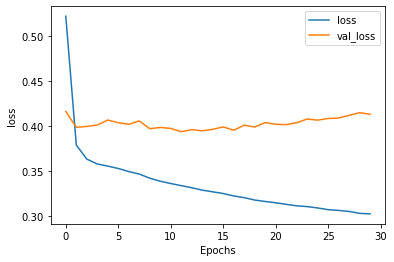

In [11]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [12]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[2]))
print(training_sentences[2])

# 1 = sarcasm, 0 = not sarcasm
print(labels[2])

mom starting to fear <OOV> <OOV> series <OOV> thing she will have to <OOV> ? ?
mom starting to fear son's web series closest thing she will have to grandchild
1


In [13]:
e = model.layers[0]
weights = e.get_weights()[0]

print(weights.shape) # shape: (vocab_size, embedding_dim)

(1000, 16)


In [14]:
# write files containing vectors and meta (words) - formatting required by TF Embedding Projector

import io

out_v = io.open('vecs_sarcasm.tsv', 'w', encoding='utf-8')
out_m = io.open('meta_sarcasm.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

https://projector.tensorflow.org/

In [16]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

[[0.4022996 ]
 [0.55063754]]
